In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
import glob 

path = 'data/PRSA_Data_20130301-20170228/'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [10]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df[['year', 'month', 'day','hour']])
    df.drop(columns=['year', 'month', 'day','hour','No'],inplace=True)
    df.set_index('date_time',inplace=True)
    return df

In [11]:
df_preprocessed=[pre_process(df) for df in df_list]

In [39]:
df_preprocessed[0]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
date_time,,,,,,,,,,,,,
2013-03-01 00:00:00,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
2013-03-01 01:00:00,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2013-03-01 02:00:00,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
2013-03-01 03:00:00,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
2013-03-01 04:00:00,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,14.0,58.0,4.0,19.0,500.0,56.0,12.8,1009.9,-17.0,0.0,NNW,3.1,Gucheng
2017-02-28 20:00:00,27.0,83.0,6.0,60.0,700.0,26.0,11.1,1010.4,-15.5,0.0,NW,1.9,Gucheng
2017-02-28 21:00:00,22.0,37.0,7.0,52.0,600.0,27.0,10.5,1010.8,-15.9,0.0,N,2.3,Gucheng


In [12]:
df_group=pd.concat(df_preprocessed)

In [13]:
def train_test_split(data,split_fraction,feature_keys):
    data=data[feature_keys]
    train_split = int(split_fraction * int(data.shape[0]))
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    data = (data - data_mean) / data_std
    train_data = data.iloc[0 : train_split - 1]
    val_data = data.iloc[train_split:]
    return train_data,val_data

def create_batch(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=data[future+lag-1:].values
    return X,y

def create_batch_multistep(data,lag,future):
    df_lag=pd.concat([data[:-future].shift(i) for i in range(lag-1,-1,-1)],axis=1).dropna()
    df_future=pd.concat([data[lag-1:].shift(-i) for i in range(1,future+1)],axis=1).dropna()
    #df_lag.columns=['pm_'+str(i) for i in range(lag,-1,1)]
    X=df_lag.values
    y=df_future.values
    return X,y

In [42]:
import numpy as np 

split_fraction = 0.8
feature_keys = ['PM2.5','TEMP']
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=6
past=6
dataset_names=list()
for item_id, gdf in df_group.groupby('station'):
    gdf.fillna(method='ffill',inplace=True)
    train,test=train_test_split(gdf,split_fraction,feature_keys)
    X_train,y_train=create_batch_multistep(train,past,future)
    X_test,y_test=create_batch_multistep(test,past,future)
    X_train_datasets.append(X_train)
    y_train_datasets.append(y_train)
    X_test_datasets.append(X_test)
    y_test_datasets.append(y_test)
    dataset_names.append(item_id)
X_train_datasets=np.stack(X_train_datasets,axis=0)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
y_test_datasets=np.stack(y_test_datasets,axis=0)

In [41]:
y_train_datasets.shape

(12, 28039, 6)

In [19]:
import jax 
import jax.numpy as jnp 

def get_dataloader(X,y,batch_size,key,axis=0):
    num_train=X.shape[axis]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[:,batch_indices,:], y[:,batch_indices]

In [20]:
import optax
from flax import linen as nn
from functools import partial

class LSTM(nn.Module):

    @nn.remat    
    @nn.compact   
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]
    
def log_likelihood(params, x, y):
    preds = jax.vmap(model.apply, (0, 0))(params, jnp.array(x[:,:,:,np.newaxis]))
    return jnp.mean(optax.l2_loss(y,preds).sum(axis=-1))

grad_log_post=jax.jit(jax.grad(log_likelihood))

@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree_map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree_map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree_map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree_map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree_map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(log_post(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1]))
    return samples,loss


In [21]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [22]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
inputs = jax.random.randint(key,(batch_size,past,1),0, 10,).astype(jnp.float32)
key_tasks=jax.random.split(key_model,n_groups)
params_tasks = jax.vmap(model.init, (0, None))(key_tasks, inputs)

In [23]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 10,
                             dt, params_tasks,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

iteration 0, loss 0.83
iteration 1, loss 0.78
iteration 2, loss 0.86
iteration 3, loss 0.64
iteration 4, loss 0.58
iteration 5, loss 0.47
iteration 6, loss 0.70
iteration 7, loss 1.04
iteration 8, loss 0.98
iteration 9, loss 0.87


In [24]:
X_test=X_test_datasets[:,:,:,np.newaxis]
params=samples[-1]
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [25]:
jax.tree_map(jnp.shape,params)

{'params': {'Dense_0': {'bias': (12, 6), 'kernel': (12, 32, 6)},
  'LSTMCell_0': {'hf': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'hg': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'hi': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'ho': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'if': {'kernel': (12, 1, 32)},
   'ig': {'kernel': (12, 1, 32)},
   'ii': {'kernel': (12, 1, 32)},
   'io': {'kernel': (12, 1, 32)}},
  'LSTMCell_1': {'hf': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'hg': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'hi': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'ho': {'bias': (12, 32), 'kernel': (12, 32, 32)},
   'if': {'kernel': (12, 32, 32)},
   'ig': {'kernel': (12, 32, 32)},
   'ii': {'kernel': (12, 32, 32)},
   'io': {'kernel': (12, 32, 32)}}}}

In [27]:
from sklearn import metrics
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:],squared=True)
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Aotizhongxin, RMSE : 0.24, MAE :0.29, R2 :0.63
task : Changping, RMSE : 0.23, MAE :0.27, R2 :0.62
task : Dingling, RMSE : 0.19, MAE :0.24, R2 :0.72
task : Dongsi, RMSE : 0.27, MAE :0.30, R2 :0.61
task : Guanyuan, RMSE : 0.26, MAE :0.30, R2 :0.66
task : Gucheng, RMSE : 0.28, MAE :0.29, R2 :0.65
task : Huairou, RMSE : 0.21, MAE :0.24, R2 :0.67
task : Nongzhanguan, RMSE : 0.24, MAE :0.28, R2 :0.63
task : Shunyi, RMSE : 0.26, MAE :0.28, R2 :0.62
task : Tiantan, RMSE : 0.24, MAE :0.28, R2 :0.66
task : Wanliu, RMSE : 0.22, MAE :0.28, R2 :0.62
task : Wanshouxigong, RMSE : 0.27, MAE :0.29, R2 :0.66
-------------------------------------------------------
RMSE : 0.24, MAE :0.28, R2 :0.65


In [38]:
ensemble_pred=list()
X_test=X_test_datasets[:,:,:,np.newaxis]
for i in range(len(samples)):
    preds=jax.vmap(model.apply, (0, 0))(samples[i], X_test)
    ensemble_pred.append(preds)

In [29]:
ensemble_pred=np.stack(ensemble_pred,axis=2)

In [30]:
mean_pred=np.mean(ensemble_pred,axis=2)
std_pred=np.std(ensemble_pred,axis=2)

In [34]:
y_test_datasets.shape

(12, 7002, 6)

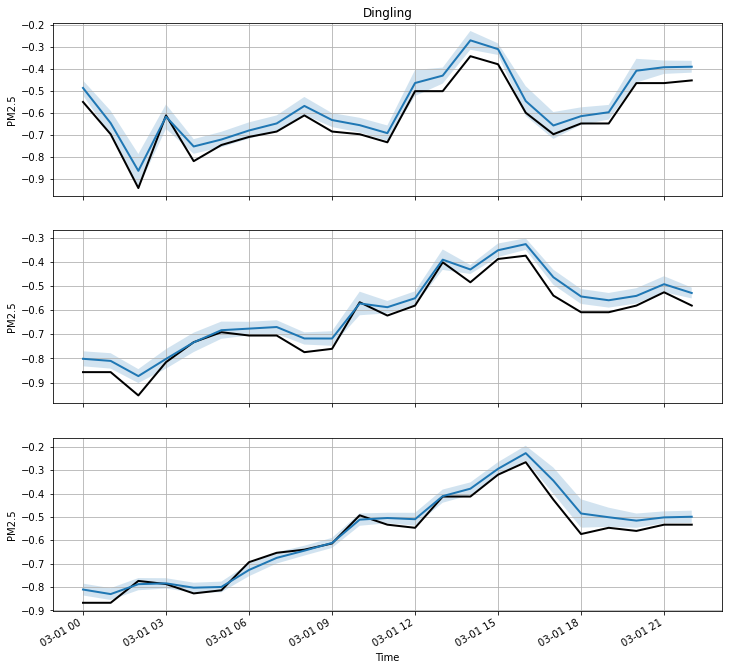

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=1
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[1,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,2:25,future_pred]-std_pred[1,2:25,future_pred]),np.ravel(mean_pred[1,2:25,future_pred]+std_pred[1,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()